In [2]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
L = 3.0  # длина стержня
T = 1.0
h = 0.1
a = 2
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


In [4]:
def pc(u):
    return torch.full_like(u,1)
def K_(u):
    return torch.full_like(u,1)*a
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # производная по времени
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # вторая производная по x
    K = K_(u)
    du_x = dde.grad.jacobian(u,x,i=0,j=0)
    #dK_u = dde.grad.jacobian(K,u, i = 0, j = 0)
    
    return du_t - (K * du_xx) #+ dK_u*(du_x)**2)/pc(u)

def boundary_left(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and not np.isclose(x[1],0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1],0)

def boundary_left_0(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and np.isclose(x[1],0)
def boundary_right_0(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and np.isclose(x[1],0)

def right_condition(x, u, _):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return u
def left_condition(x,u,_):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return u
def initial_condition(x):
    return np.sin(np.pi*x[:,0:1]/L)
bc_right = dde.OperatorBC(geomtime, right_condition, boundary_right)
bc_left = dde.OperatorBC(geomtime, left_condition, boundary_left)

ic = dde.IC(
    geomtime,
    initial_condition,
    lambda _, on_initial: on_initial,
)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right,ic],
    num_domain=1000,  # точек внутри области
    num_boundary=100, # точек на границе
    num_initial=100,  # точек для начального условия
    
)



In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad

# Параметры задачи
         # Длина стержня
alpha = a     # Коэффициент температуропроводности
T_final = 1     # Конечное время

# Создаем сетку (x, t)
Nx = 100          # Число точек по пространству
Nt = 100          # Число точек по времени
x = np.linspace(0, L, Nx)
t = np.linspace(0, T_final, Nt)
XX, TT = np.meshgrid(x, t)  # Формируем сетку для векторных вычислений

# Начальное условие (можно изменить на любую функцию)
def initial_condition(x):
    return np.sin(np.pi * x / L)  # Простое начальное условие
    # return x * (L - x)         # Другой вариант (раскомментировать для использования)

# Вычисляем коэффициенты Фурье B_n для начального условия
def fourier_coeff(n, L):
    def integrand(x):
        return initial_condition(x) * np.sin(n * np.pi * x / L)
    Bn, _ = quad(integrand, 0, L)
    return (2 / L) * Bn

# Точное решение (учитывает первые N_terms членов ряда Фурье)
def exact_solution(x, t, N_terms=20):
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        Bn = fourier_coeff(n, L)
        u += Bn * np.sin(n * np.pi * x / L) * np.exp(-alpha * (n * np.pi / L)**2 * t)
    return u

# Векторизуем функцию для работы с сеткой
U_exact = np.zeros_like(XX)
for i in range(Nt):
    U_exact[i, :] = exact_solution(XX[i, :], TT[i, :])


    

Compiling model...
'compile' took 0.000289 s

Training model...

0         [4.51e+00, 2.18e-01, 4.91e+00, 2.65e+01]    [4.51e+00, 2.18e-01, 4.91e+00, 2.65e+01]    []  
1000      [2.58e-01, 4.62e-02, 1.52e-01, 3.18e-01]    [2.58e-01, 4.62e-02, 1.52e-01, 3.18e-01]    []  

Best model at step 1000:
  train loss: 7.74e-01
  test loss: 7.74e-01
  test metric: []

'train' took 4.108754 s

Compiling model...
'compile' took 0.000204 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
1000      [2.59e-01, 4.62e-02, 1.52e-01, 3.18e-01]    [2.58e-01, 4.62e-02, 1.52e-01, 3.18e-01]    []  
2000      [2.20e-03, 6.46e-05, 8.58e-05, 1.91e-04]    [2.22e-03, 6.46e-05, 8.58e-05, 1.91e-04]    []  
2253      [1.12e-03, 9.47e-05, 1.37e-04, 2.33e-04]    [1.10e-03, 9.47e-05, 1.37e-04, 2.33e-04]    []  

Best model at step 2253:
  train loss: 1.58e-03
  test loss: 1.57e-03
  test metric: []

'train' took 7.003401 s

1 layers of 20 

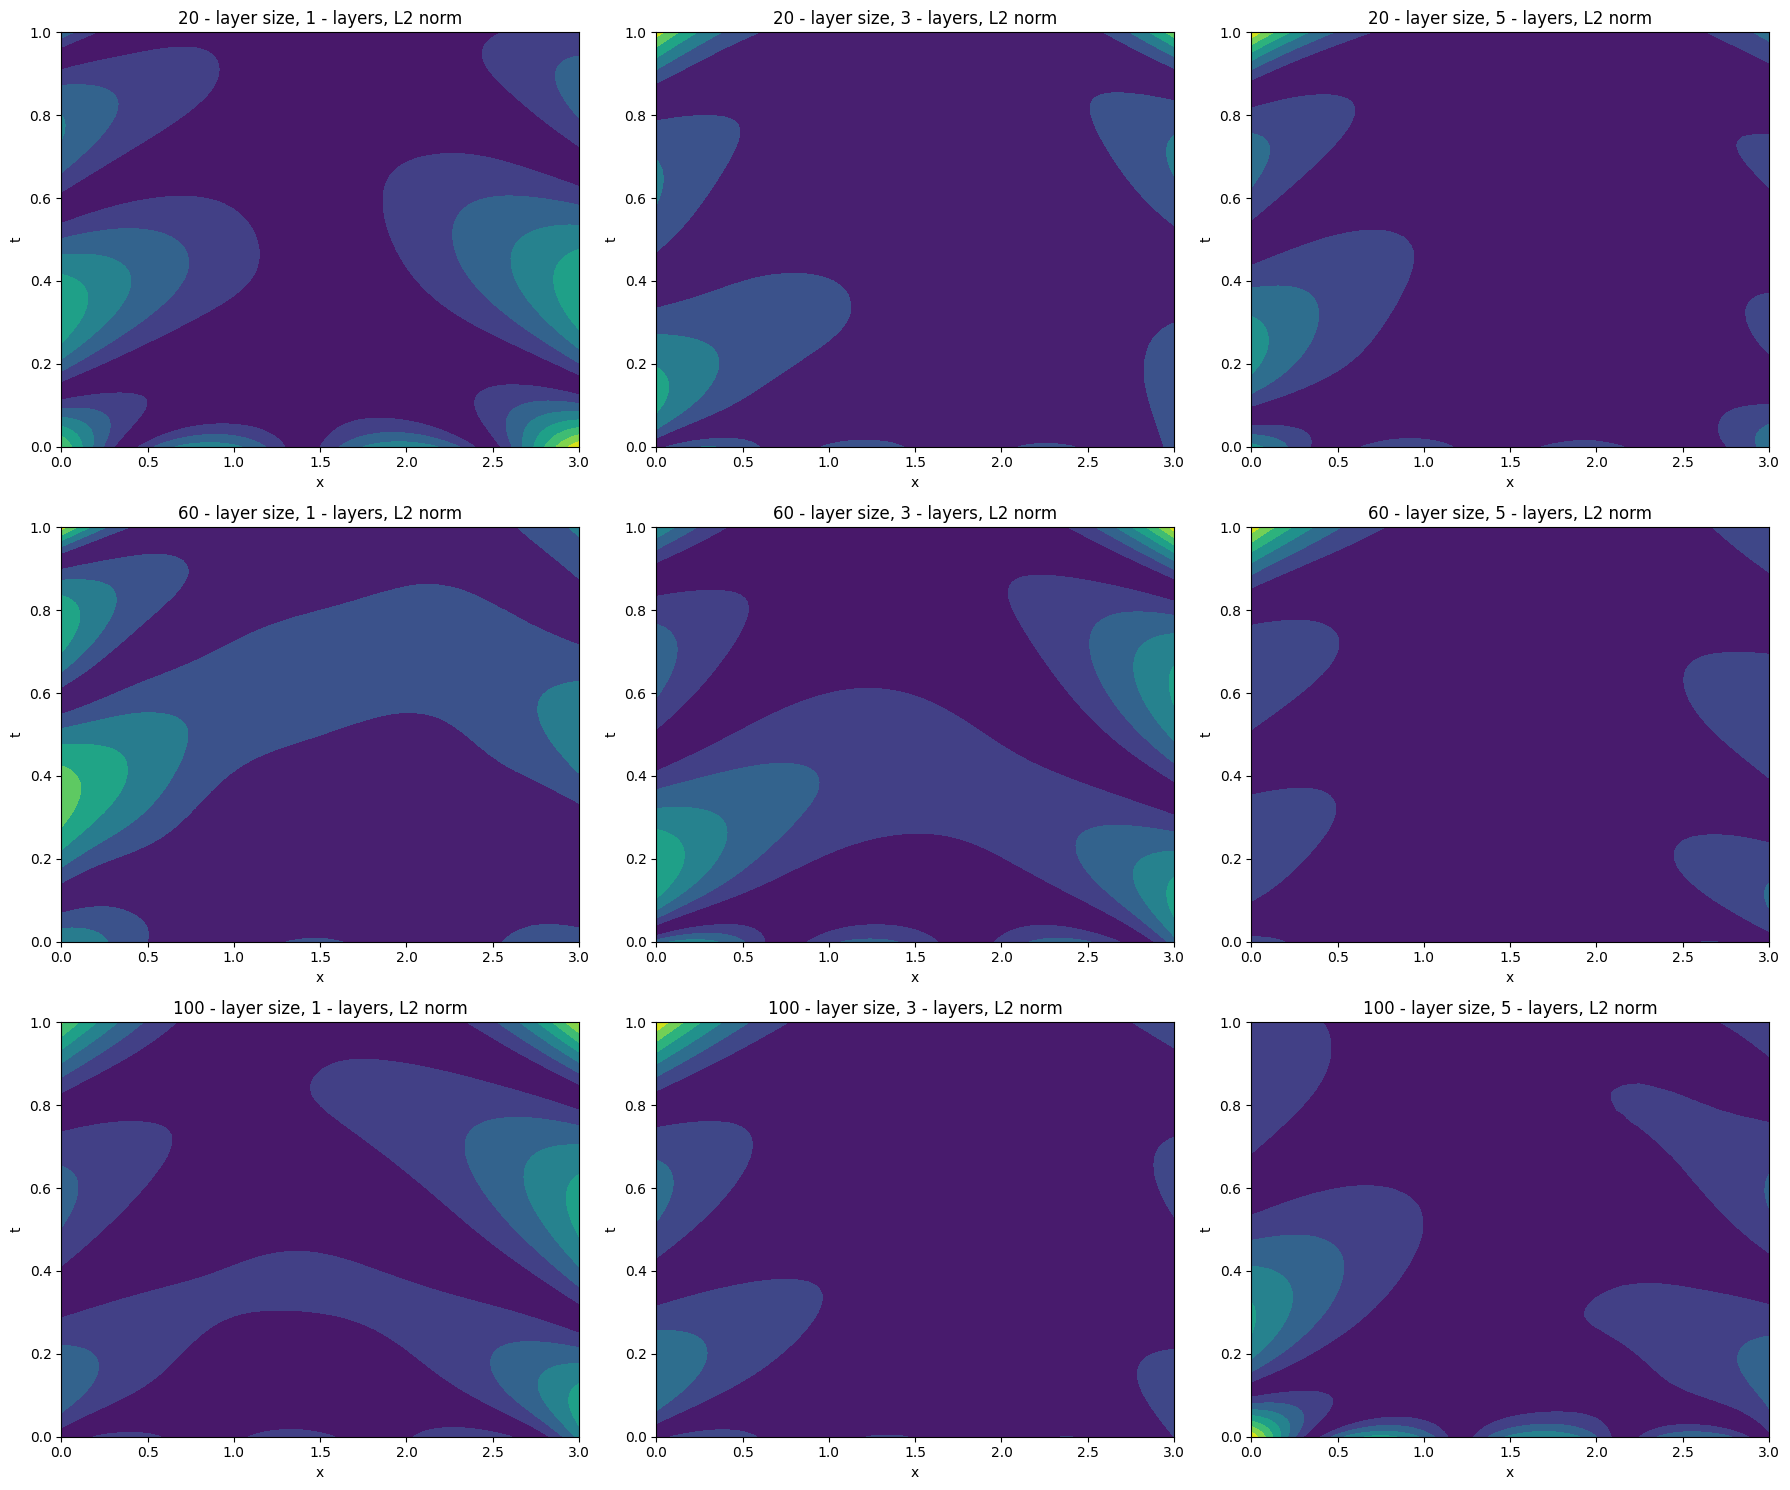

In [88]:
fig = plt.figure(figsize=(18,15))

losshistories = []
for i in range(1,6,2):
        for j in range(1,6,2):

            net = dde.nn.FNN(
                [2] + [20*i] * j + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
                "tanh",
                "Glorot normal",
            )
            # Модель и обучение
            model = dde.Model(data, net)
            resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

            model.compile("adam", lr=1e-2, loss=torch.nn.MSELoss(reduction='sum'), loss_weights=[1,1,1,1])
            model.train(iterations=1000,callbacks=[resampler] )
            model.compile('L-BFGS', loss = torch.nn.MSELoss(reduction='sum'), loss_weights= [1,1,1,1])
            losshistory, train_state = model.train()
            losshistories.append(losshistory)
            n_x, n_t = 100, 100
            x_vals = np.linspace(0, L, n_x)
            t_vals = np.linspace(0, T, n_t)
            X, T_grid = np.meshgrid(x_vals, t_vals)
            XT = np.vstack((X.ravel(), T_grid.ravel())).T
            
            U_pinn = model.predict(XT).reshape(n_t, n_x)
            U_max_error = np.max(U_pinn - U_exact)
            U_diff = np.sqrt((U_pinn - U_exact)**2/U_pinn.shape[1])
            ax = fig.add_subplot(3,3,(i-1)*3//2+(j-1)//2+1)
            ax.set_title(f'{i*20} - layer size, {j} - layers, L2 norm')
            ax.set_xlabel("x"); ax.set_ylabel("t")
            ax.contourf(x_vals, t_vals, U_diff)
            print(f'{j} layers of {i*20} size')
            print('Average L2 norm -', np.mean(U_diff))
            print('Max error - ', U_max_error) 
plt.tight_layout()
plt.show()

            

            
            



Compiling model...
'compile' took 0.004669 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.61e+00, 1.89e-03, 4.13e-02, 4.72e+01]    [1.61e+00, 1.89e-03, 4.13e-02, 4.72e+01]    []  
1000      [6.29e-02, 4.90e-03, 7.36e-02, 6.59e-02]    [6.36e-02, 4.90e-03, 7.36e-02, 6.59e-02]    []  

Best model at step 1000:
  train loss: 2.07e-01
  test loss: 2.08e-01
  test metric: []

'train' took 37.421257 s

Compiling model...
'compile' took 0.000582 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
1000      [6.40e-02, 4.90e-03, 7.36e-02, 6.59e-02]    [6.36e-02, 4.90e-03, 7.36e-02, 6.59e-02]    []  
2000      [2.90e-05, 3.26e-06, 1.79e-06, 4.90e-07]    [3.04e-05, 3.26e-06, 1.79e-06, 4.90e-07]    []  
2038      [2.72e-05, 3.55e-06, 1.73e-06, 3.27e-07]    [2.83e-05, 3.55e-06, 1.73e-06, 3.27e-07]    []  

Best model at step

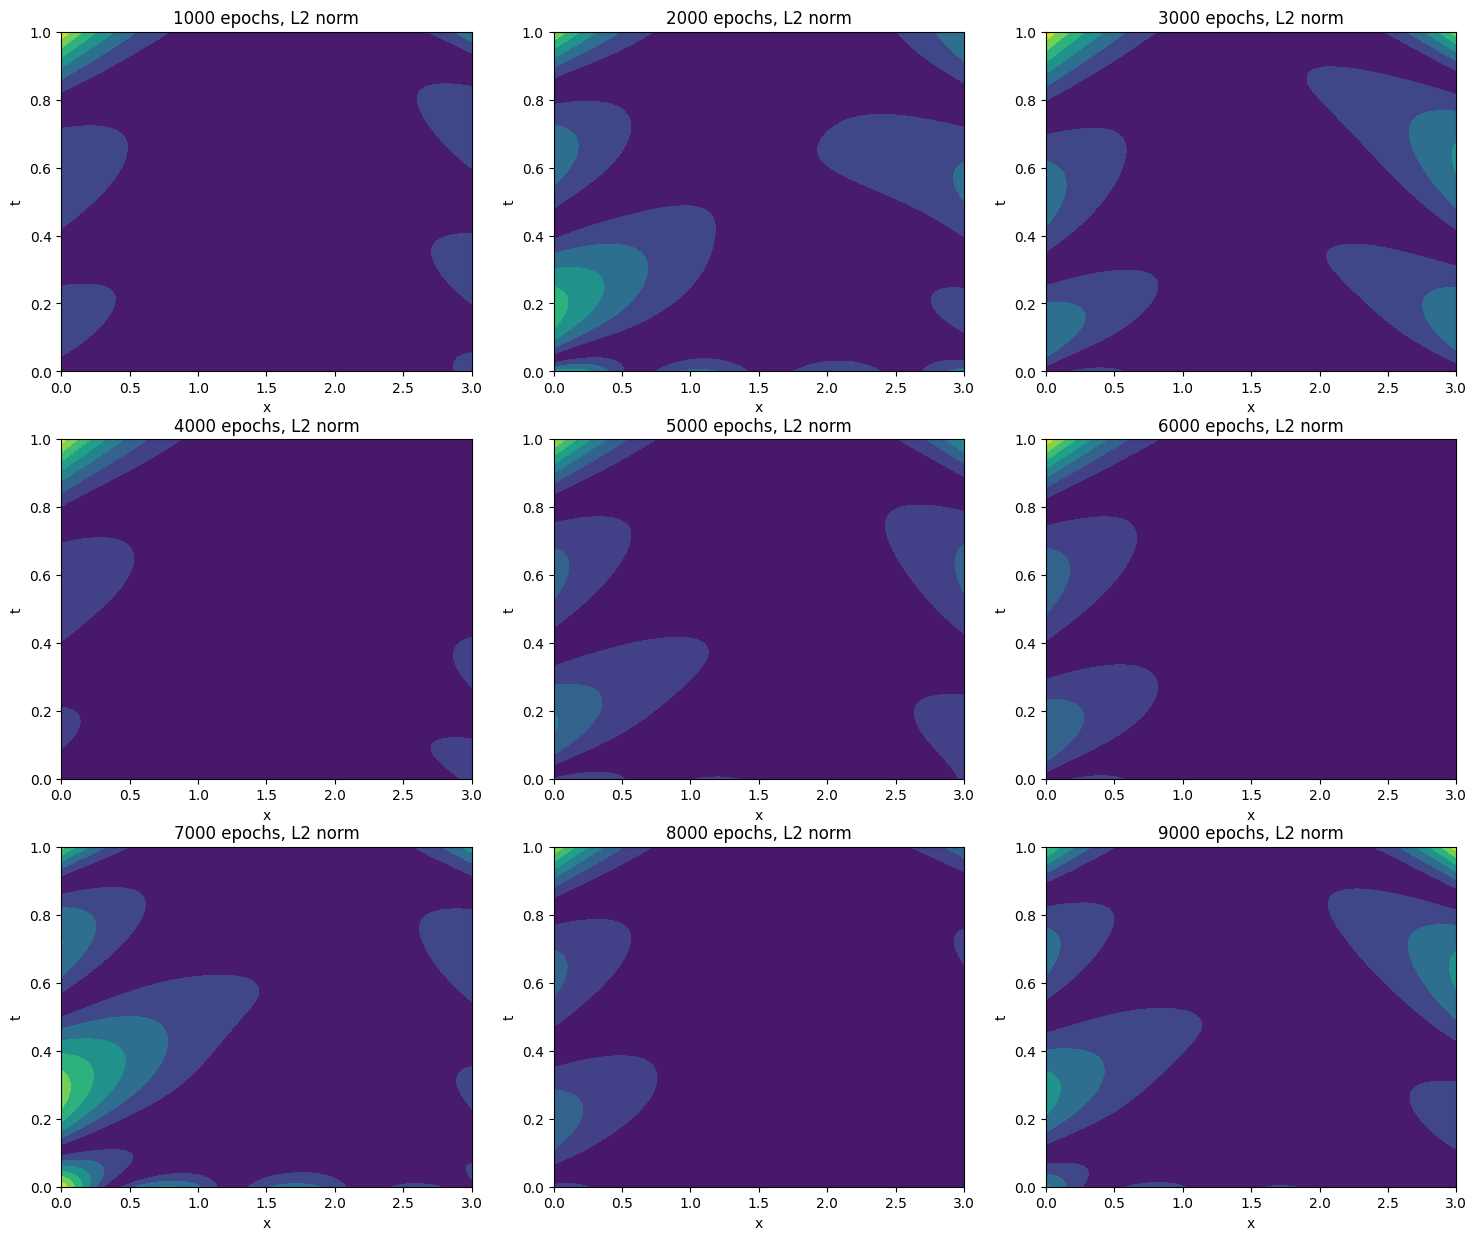

In [96]:

            # Модель и обучение
fig = plt.figure(figsize=(18,15))

losshistories = []
for i in range(1,10):
    
    net = dde.nn.FNN(
                [2] + [100] * 5 + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
                "tanh",
                "Glorot normal",
            )
    model = dde.Model(data, net)
    resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох
    
    model.compile("adam", lr=1e-3, loss=torch.nn.MSELoss(reduction='sum'), loss_weights=[1,1,1,1])
    model.train(iterations=1000*i,callbacks=[resampler] )
    model.compile('L-BFGS', loss = torch.nn.MSELoss(reduction='sum'), loss_weights= [1,1,1,1])
    losshistories.append(model.train())
    n_x, n_t = 100, 100
    x_vals = np.linspace(0, L, n_x)
    t_vals = np.linspace(0, T, n_t)
    X, T_grid = np.meshgrid(x_vals, t_vals)
    XT = np.vstack((X.ravel(), T_grid.ravel())).T
            
    U_pinn = model.predict(XT).reshape(n_t, n_x)
    U_max_error = np.max(U_pinn - U_exact)
    U_diff = np.sqrt((U_pinn - U_exact)**2/U_pinn.shape[1])
    ax = fig.add_subplot(3,3,i)
    ax.set_title(f'{i*1000} epochs, L2 norm')
    ax.set_xlabel("x"); ax.set_ylabel("t")
    ax.contourf(x_vals, t_vals, U_diff)
    print(f'{i*1000} epochs')
    print('Average L2 norm -', np.mean(U_diff))
    print('Max error - ', U_max_error) 
    



Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


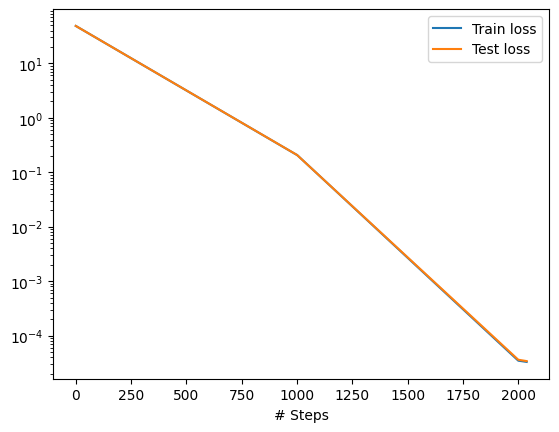

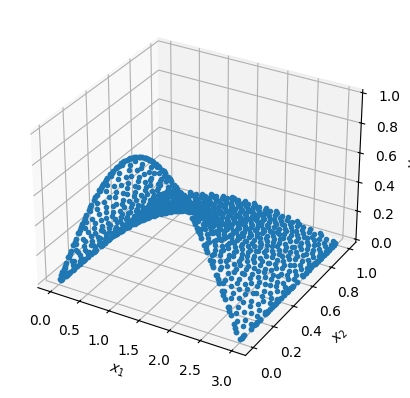

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


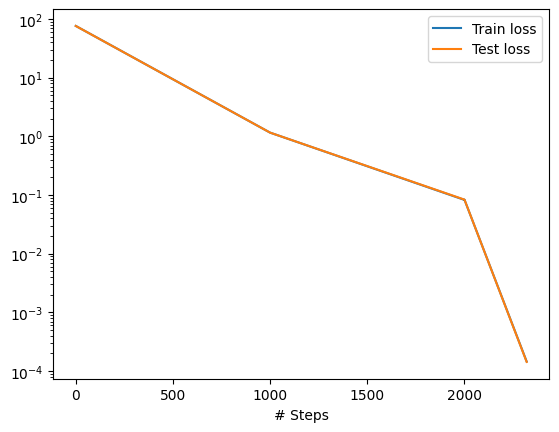

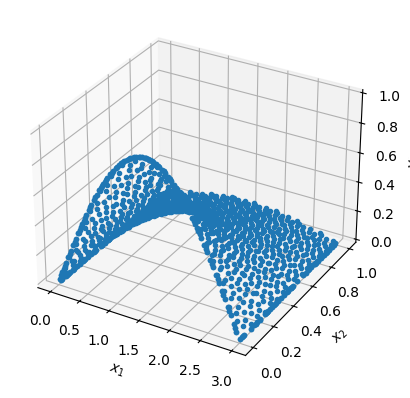

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


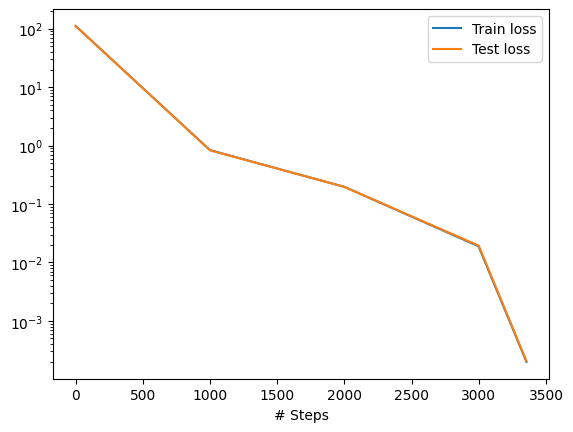

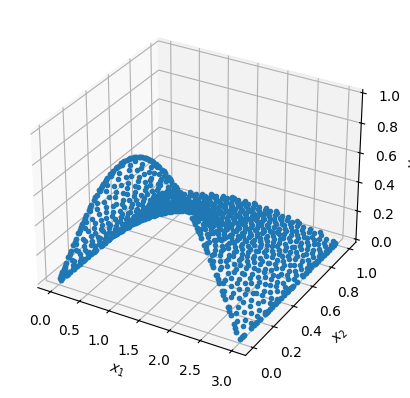

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


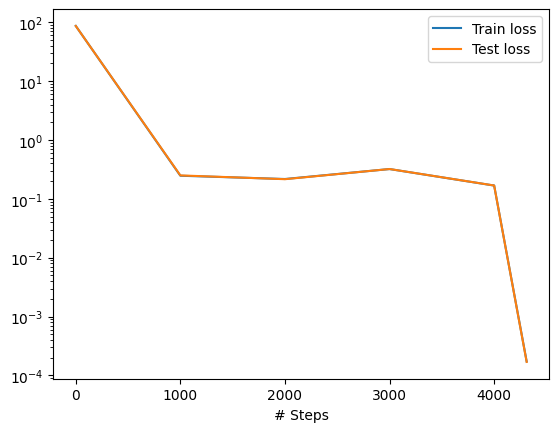

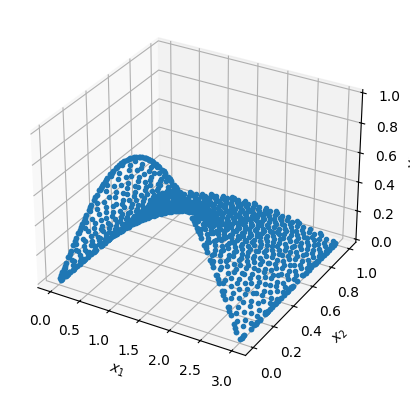

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


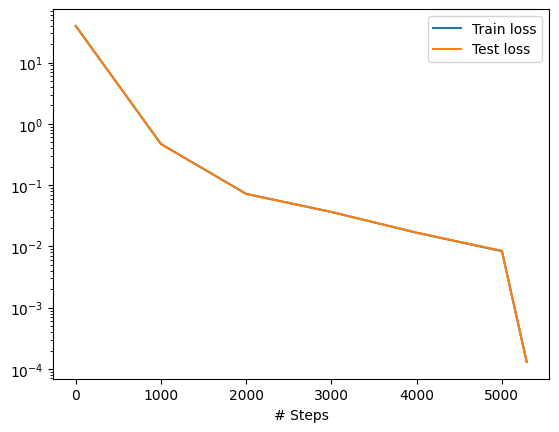

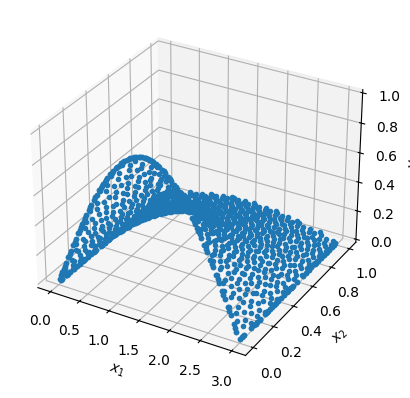

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


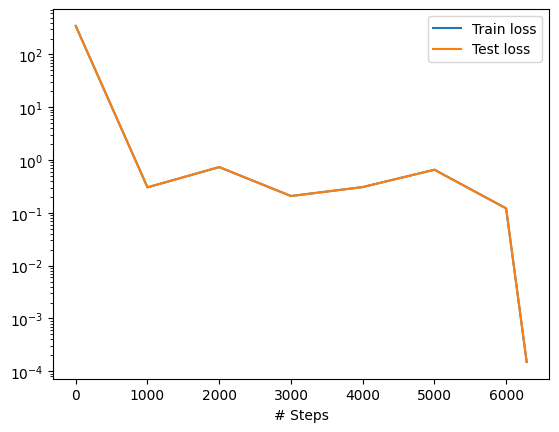

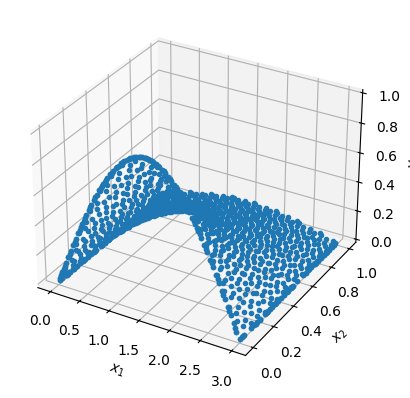

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


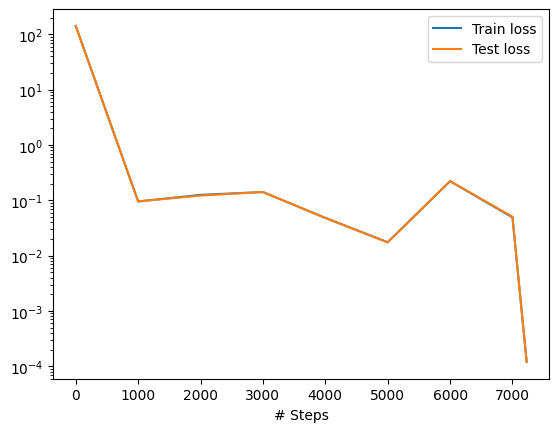

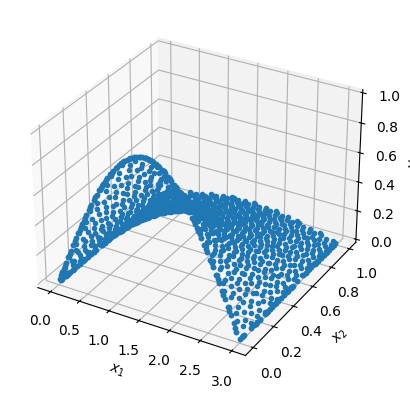

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


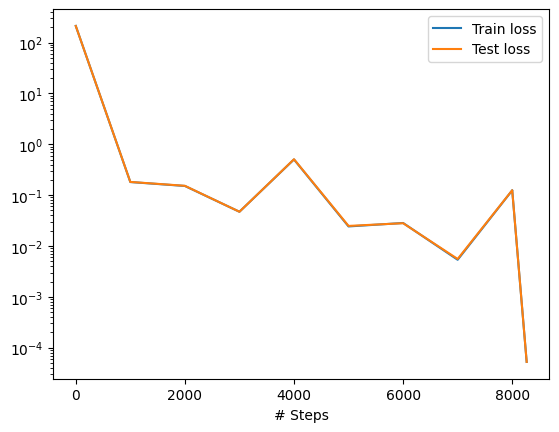

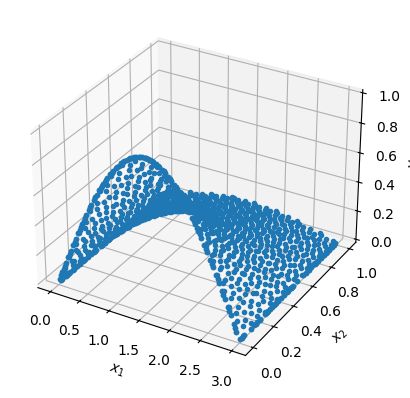

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


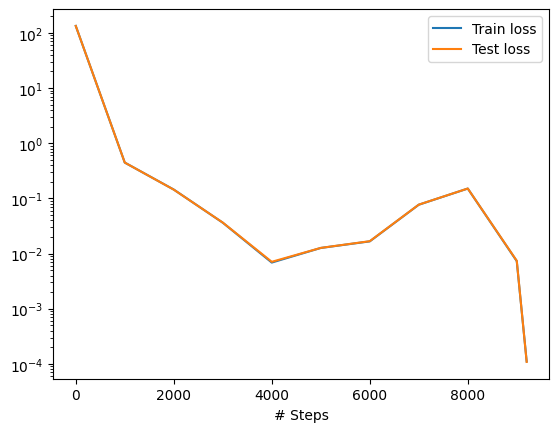

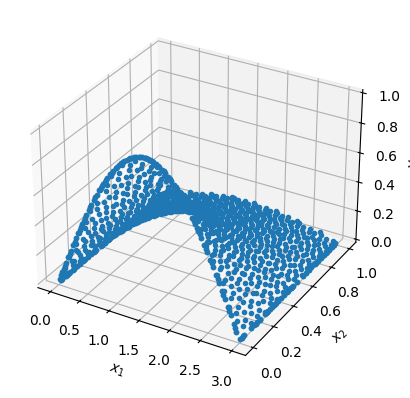

In [97]:
for lh in losshistories:
    dde.saveplot(*lh)

In [6]:
for i in range(1,4):
    data = dde.data.TimePDE(
        geomtime,
        pde,
        [bc_left, bc_right,ic],
        num_domain=1000*i,  # точек внутри области
        num_boundary=100*i, # точек на границе
        num_initial=100*i,  # точек для начального условия
        
    )
    net = dde.nn.FNN(
                    [2] + [60] * 1 + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
                    "tanh",
                    "Glorot normal",
                )
    model = dde.Model(data, net)
    resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох
        
    model.compile("adam", lr=1e-3, loss=torch.nn.MSELoss(reduction='sum'), loss_weights=[1,1,1,1])
    model.train(iterations=4000,callbacks=[resampler] )
    model.compile('L-BFGS', loss = torch.nn.MSELoss(reduction='sum'), loss_weights= [1,1,1,1])
    losshistory, train_state = model.train()

Compiling model...
'compile' took 1.258374 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.71e+01, 1.62e+00, 2.08e+01, 1.93e+01]    [8.71e+01, 1.62e+00, 2.08e+01, 1.93e+01]    []  
1000      [7.90e-01, 1.55e+00, 1.07e+00, 4.14e+00]    [7.96e-01, 1.55e+00, 1.07e+00, 4.14e+00]    []  
2000      [2.96e-01, 7.90e-01, 9.90e-01, 2.06e+00]    [2.97e-01, 7.90e-01, 9.90e-01, 2.06e+00]    []  
3000      [4.08e-01, 1.18e-01, 3.05e-01, 6.20e-01]    [4.28e-01, 1.18e-01, 3.05e-01, 6.20e-01]    []  
4000      [2.05e-01, 6.59e-02, 1.00e-01, 2.16e-01]    [2.14e-01, 6.59e-02, 1.00e-01, 2.16e-01]    []  

Best model at step 4000:
  train loss: 5.87e-01
  test loss: 5.96e-01
  test metric: []

'train' took 18.666293 s

Compiling model...
'compile' took 0.000425 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
4000      [2.07e-01